# 545 M2 Project: Digital Humanities Text Analysis

- Alishan Bhayani
- Tochukwu "Sylvester" Nwizu
- Giuseppe Schintu


`In this project, we aim to provide text Analysis in three different areas:`
- Character Description Analysis
- Sentiment Analysis
- ? Alishan ??

## Run global libraries and functions

In [2]:
import requests, re, nltk
from bs4 import BeautifulSoup
from nltk import clean_html, download
from nltk.corpus import words, names
from collections import Counter
import operator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords', 'words', 'names', 'averaged_perceptron_tagger', 'punkt') #uncomment if not yet downloaded
english_words = set(words.words())
english_names = set(names.words())

# we may not care about the usage of stop words
stop_words = nltk.corpus.stopwords.words('english') + [
 'ut', '\'re','.', ',', '--', '\'s', '?', ')', '(', ':', '\'',
 '\"', '-', '}', '{', '&', '|', u'\u2014' ]

# We most likely would like to remove html markup
def cleanHtml (html):
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')
    return soup .get_text()

# We also want to remove special characters, quotes, etc. from each word
def cleanWord (w):
    # r in r'[.,"\']' tells to treat \ as a regular character 
    # but we need to escape ' with \'
    # any character between the brackets [] is to be removed 
    wn = re.sub('[,"\.\'&\|:@>*;/=]', "", w)
    # get rid of numbers
    return re.sub('^[0-9\.]*$', "", wn)
       
# define a function to get text/clean/calculate frequency
def get_wf (URL, w_ml):
    # first get the web page
    r = requests .get(URL)
    
    # Now clean
    # remove html markup
    t = cleanHtml (r .text) .lower()
    
    # split string into an array of words using any sequence of spaces "\s+" 
    wds = re .split('\s+',t)
    
    # remove periods, commas, etc stuck to the edges of words
    for i in range(len(wds)):
        wds [i] = cleanWord (wds [i])
    
    # If satisfied with results, lets go to the next step: calculate frequencies
    # We can write a loop to create a dictionary, but 
    # there is a special function for everything in python
    # in particular for counting frequencies (like function table() in R)
    wf = Counter (wds)
    
    # Remove stop words from the dictionary wf
    for k in stop_words:
        wf. pop(k, None)
        
    #how many regular words in the document?
    tw = 0
    for w in wf:
       tw += wf[w] 
        
    
    # Get ordered list
    wfs = sorted (wf .items(), key = operator.itemgetter(1), reverse=True)
    ml = min(len(wfs),w_ml)

    #Reverse the list because barh plots items from the bottom
    return (wfs [ 0:ml ] [::-1], tw)

def plotTwoLists(wf_ee, wf_bu, title, wf_ee_title, wf_bu_title):
    sns.set(style="whitegrid")
    f, (ax2, ax1) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

    f.suptitle(title, fontsize=20)
    
    wf_bu_sorted = sorted(wf_bu, key=lambda x: x[1], reverse=True)
    wf_ee_sorted = sorted(wf_ee, key=lambda x: x[1], reverse=True)

    sns.barplot(x=[x[1] for x in wf_bu_sorted], y=[x[0] for x in wf_bu_sorted], ax=ax2)
    ax2.set_title(wf_bu_title)
    ax2.set(ylabel='')

    sns.barplot(x=[x[1] for x in wf_ee_sorted], y=[x[0] for x in wf_ee_sorted], ax=ax1)
    ax1.set_title(wf_ee_title)
    ax2.set_yticklabels([])
    ax1.set_yticklabels([])

    # Adding words inside the bars
    for i, (word, freq) in enumerate(wf_bu_sorted):
        ax2.text(freq, i, f' {word}', va='center', fontsize=10)

    for i, (word, freq) in enumerate(wf_ee_sorted):
        ax1.text(freq, i, f' {word}', va='center', fontsize=10)

    # Remove larger axis labels and grid lines
    ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.grid(False)
    ax1.grid(False)
    plt.subplots_adjust(wspace=0.5)


def find_character_context(text, character_name, context_window=25):

    # split string into an array of words using any sequence of spaces "\s+" 
    words = re .split('\s+',text)

    # remove periods, commas, etc stuck to the edges of words
    for i in range(len(words)):
        words [i] = cleanWord (words [i])
    
    # Find all occurrences of the character
    indices = [i for i, word in enumerate(words) if word.lower() == character_name.lower()]
    
    # Extract context for each occurrence
    contexts = []
    for index in indices:
        start = max(index - context_window, 0)
        end = min(index + context_window + 1, len(words))
        context = " ".join(words[start:end])
        contexts.append(context)
    
    return contexts


### 1. Text Selection and Reasoning

`In this analysis, we have chosen to analyze "The Adventures of Robinson Crusoe" and "The Bible from King James version". These texts provide a rich and diverse corpus for analysis. We think that the character-driven narratives and the distinct personalities of the characters make these texts ideal for a character-centric analysis.`

For our text we have The Life and Adventures of Robinson Crusoe by Daniel Defoe from Project Gutenberg:
- The Life and Adventures of Robinson Crusoe by Daniel Defoe at https://www.gutenberg.org/ebooks/521.txt.utf-8
- The scope is to read through the text and identify recurrences of the main character and attempt to identify its characteristics, traits, and attributes.

### 2. Analysis Overview
`The goal of this analysis is to examine the adjectives used in close proximity to four characters - Robinson Crusoe and Friday from "The Adventures of Robinson Crusoe", and David and Jesus from "The Bible". By analyzing a range of 25 words before and after each mention of these characters, we aim to understand how these characters are described and portrayed in their respective texts.`

##### 2.1 - Technical approach
- We want to tokenize (separate in words) and assign a tag to each word so we can identify parts of a speech (we are hoping to get our adjectives identified)
- nltk offers word_tokenize, and pos_tag for to separate a text in words with an index and then post_tag which assigns tags to each token in the form of noun, verb, adjective, etc...

In [3]:
# Read the text of the Gutenberg book into a string.
r = requests .get("http://www.gutenberg.org/ebooks/521.txt.utf-8")
text = cleanHtml (r.text) .lower()


nltk.download('averaged_perceptron_tagger')

contexts = find_character_context(text, "Crusoe", 25)

for context in contexts:
    tokens = nltk.word_tokenize(context)
    tagged = nltk.pos_tag(tokens)
    adjectives = [word for word, pos in tagged if pos.startswith('JJ')]
    print("\nAdjectives in the context: ", adjectives)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/giuseppe.schintu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



Adjectives in the context:  ['gutenberg', 'united', 'most', 'other']

Adjectives in the context:  ['january', 'english']

Adjectives in the context:  ['[', 'january', 'english', 'great']

Adjectives in the context:  ['english', 'great', 'russell']

Adjectives in the context:  ['house—the', 'journal', 'poor', 'miserable', 'dreadful', 'dismal']

Adjectives in the context:  ['several', '“', 'robin', 'poor', 'robin', '”', 'dead', 'first']

Adjectives in the context:  ['last', 'first', 'utmost']

Adjectives in the context:  ['farther', 'second', 'previous', 'old', 'copyright']


### 3. Intermediate Results

`Here, we will perform the analysis and document the findings. We will use Natural Language Processing techniques to tokenize the text, perform part-of-speech tagging, and extract the adjectives associated with each character. We will then count the frequency of each adjective and present the results in a clear and understandable format.`

- show the adjectives in a range of 25 words and see if we can describe a main chosen character Like Robinson Crusoe or Friday

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/giuseppe.schintu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


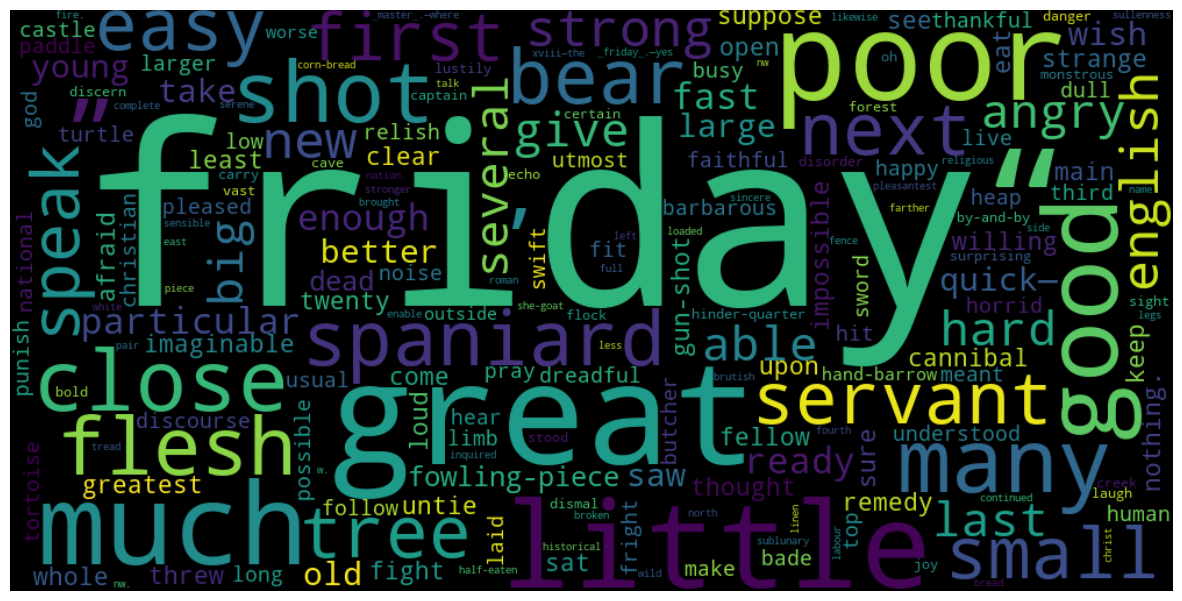

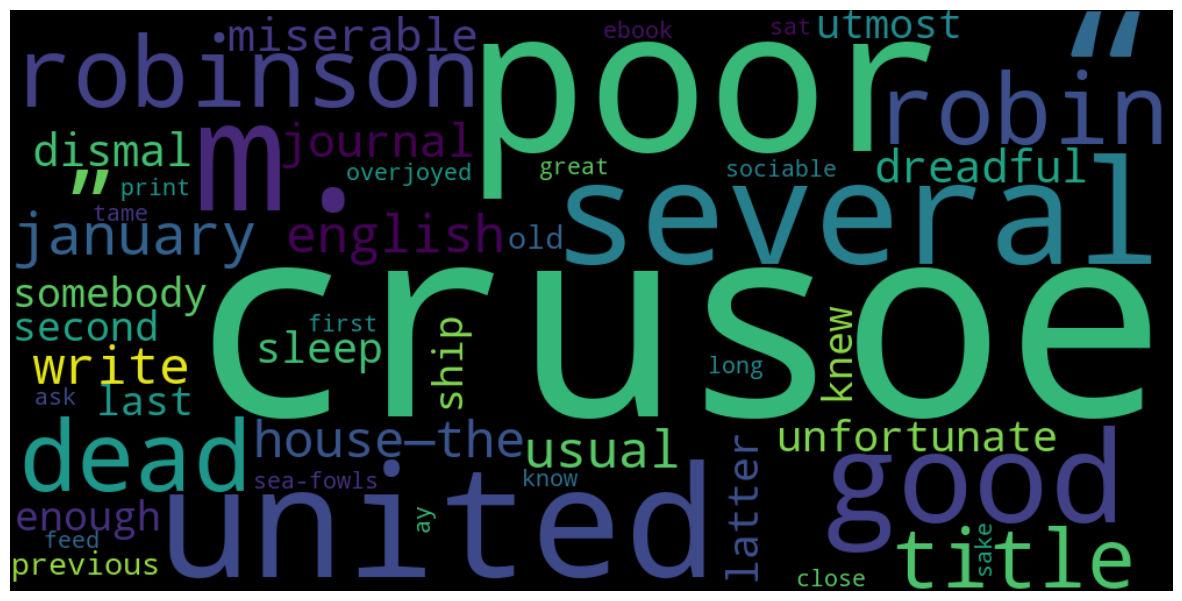

In [21]:
import nltk
import matplotlib.pyplot as plt
import requests
from wordcloud import WordCloud

nltk.download('averaged_perceptron_tagger')

# Read the text of the Gutenberg book into a string.
r = requests .get("http://www.gutenberg.org/ebooks/521.txt.utf-8")

text = cleanHtml (r.text) .lower()

tokens = nltk.word_tokenize(text)

# Remove stop words from the dictionary wf
tokens = [token for token in tokens if token not in stop_words]

tagged = nltk.pos_tag(tokens)

# Convert names to lowercase
english_names = [name.lower() for name in english_names]
name_tokens = []
# Filter out the tokens that are not in english_names
#name_tokens = [token for token in tokens if token in english_names and len(token) >= 5]

name_tokens.append("friday")
name_tokens.append("crusoe")
#name_tokens.append("crusoe")

# Get the frequency distribution of the name tokens
#freq_dist = nltk.FreqDist(name_tokens)

# Get the maximum frequency
#max_freq = max(freq_dist.values())

# Filter out the names that have the maximum frequency
#high_freq_names = [name for name, _ in freq_dist.most_common(10)]

#print(high_freq_names)


# For each high frequency name, create a graph
for name in name_tokens:

    # Create a dictionary to hold the frequency of each adjective
    adjective_freq = {}

    # Find adjectives that are within 25 words before or after the name
    for i, (word, pos) in enumerate(tagged):

        # Check if the word is the name (little hack for "crusoe" and "robinson crusoe")
        if word == name or (name == "crusoe" and word in ["robinson", "crusoe"]):
            
            # Extract 25 words before and after the name
            window = tagged[max(0, i - 15) : min(i + 15, len(tagged))]

            # Find adjectives within the window
            adjectives = [word for word, pos in window if pos.startswith('JJ')]

            # Add the frequency of each adjective to the dictionary
            for adj in adjectives:
                if adj in adjective_freq:
                    adjective_freq[adj] += 1
                else:
                    adjective_freq[adj] = 1

    # Create a word cloud
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(adjective_freq)

    # Display the word cloud
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


#### Let's try one more time with The Bible, King James Version
- https://www.gutenberg.org/ebooks/10900.txt.utf-8

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/giuseppe.schintu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


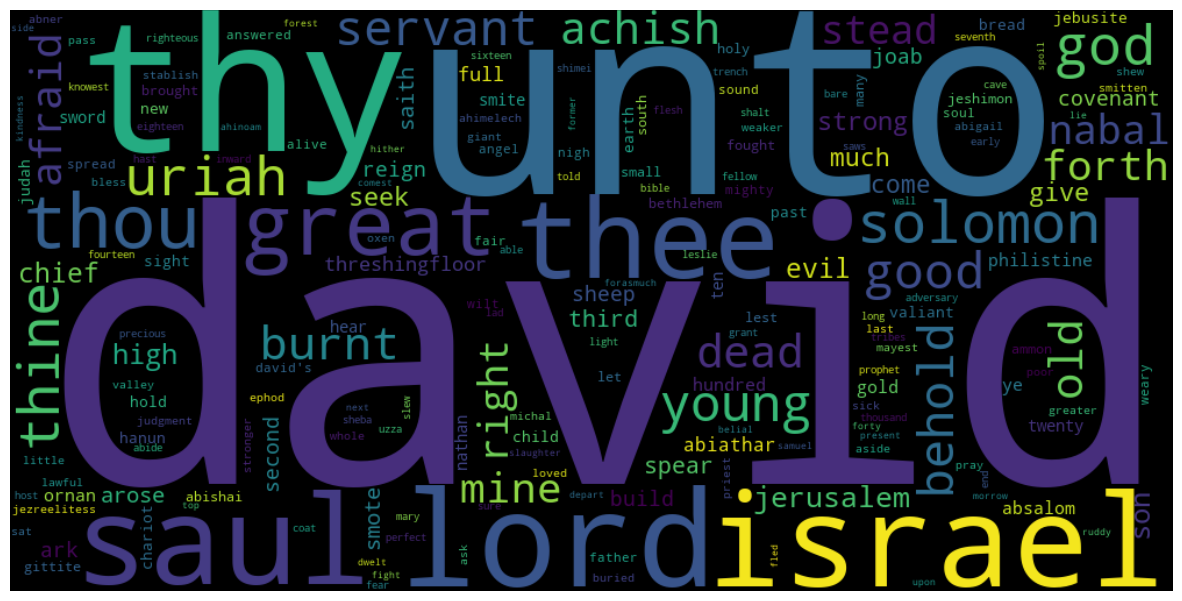

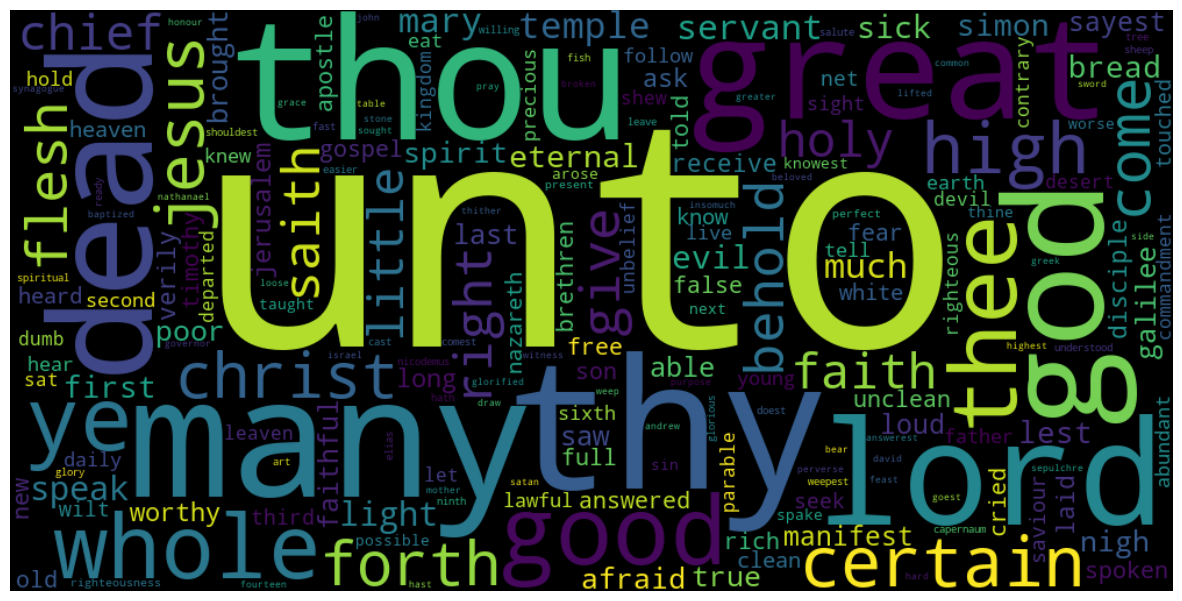

In [22]:
import nltk
import matplotlib.pyplot as plt
import requests
from wordcloud import WordCloud

nltk.download('averaged_perceptron_tagger')

# Read the text of the Gutenberg book into a string.
r = requests .get("https://www.gutenberg.org/ebooks/10900.txt.utf-8")

text = cleanHtml (r.text) .lower()

tokens = nltk.word_tokenize(text)

# Remove stop words from the dictionary wf
tokens = [token for token in tokens if token not in stop_words]

tagged = nltk.pos_tag(tokens)

name_tokens = []

name_tokens.append("david")
name_tokens.append("jesus")

# For each high frequency name, create a graph
for name in name_tokens:

    # Create a dictionary to hold the frequency of each adjective
    adjective_freq = {}

    # Find adjectives that are within 25 words before or after the name
    for i, (word, pos) in enumerate(tagged):

        # Check if the word is the name
        if word == name :
            
            # Extract 25 words before and after the name
            window = tagged[max(0, i - 15) : min(i + 15, len(tagged))]

            # Find adjectives within the window
            adjectives = [word for word, pos in window if pos.startswith('JJ')]

            # Add the frequency of each adjective to the dictionary
            for adj in adjectives:
                if adj in adjective_freq:
                    adjective_freq[adj] += 1
                else:
                    adjective_freq[adj] = 1

    # Create a word cloud
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(adjective_freq)

    # Display the word cloud
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


## 4. Final Analysis Summary and Reflection

### 4.1 - Character-Centric Analysis

#### 4.1.1 - Texts

In this analysis, we focused on two main texts: "The Adventures of Robinson Crusoe" and "The Bible from King James version". These texts provided a rich and diverse corpus for our character-centric analysis. We selected these texts due to their character-driven narratives and the distinct personalities of the characters, which made them ideal for our analysis.

##### 4.1.1.1 - "The Adventures of Robinson Crusoe"

For our analysis of "The Adventures of Robinson Crusoe," we obtained the text from Project Gutenberg. The scope of our analysis was to read through the text and identify recurrences of the main character, Robinson Crusoe. We aimed to identify and analyze his characteristics, traits, and attributes.

##### 4.1.1.2 - "The Bible from King James version"

In our analysis of "The Bible," we used the King James version as our text. Our goal was to examine the adjectives used in close proximity to four characters: Robinson Crusoe and Friday from "The Adventures of Robinson Crusoe," and David and Jesus from "The Bible." By analyzing a range of 25 words before and after each mention of these characters, we aimed to understand how they were described and portrayed in their respective texts.

